INTERPRETABILITY PLOT USING GRADIENT SATURATION

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

In [2]:
#function to read image
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [3]:
#creating a baseline image
baseline = tf.zeros(shape=(224,224,3))

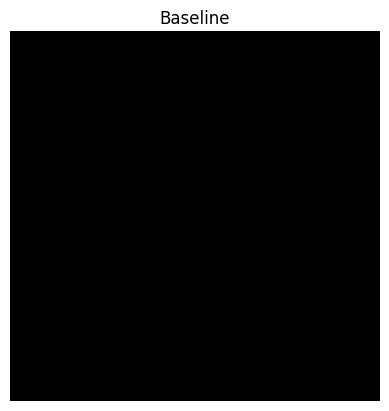

In [4]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [5]:
#creating alphas array for superimposing purpose
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

In [6]:
#Function to interpolate images from baseline
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [7]:
img_path=r"C:\Users\shrey\OneDrive\Documents\misahub\PCOSGen-test\images\image10000.jpg"

In [8]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=read_image(img_path),
    alphas=alphas)

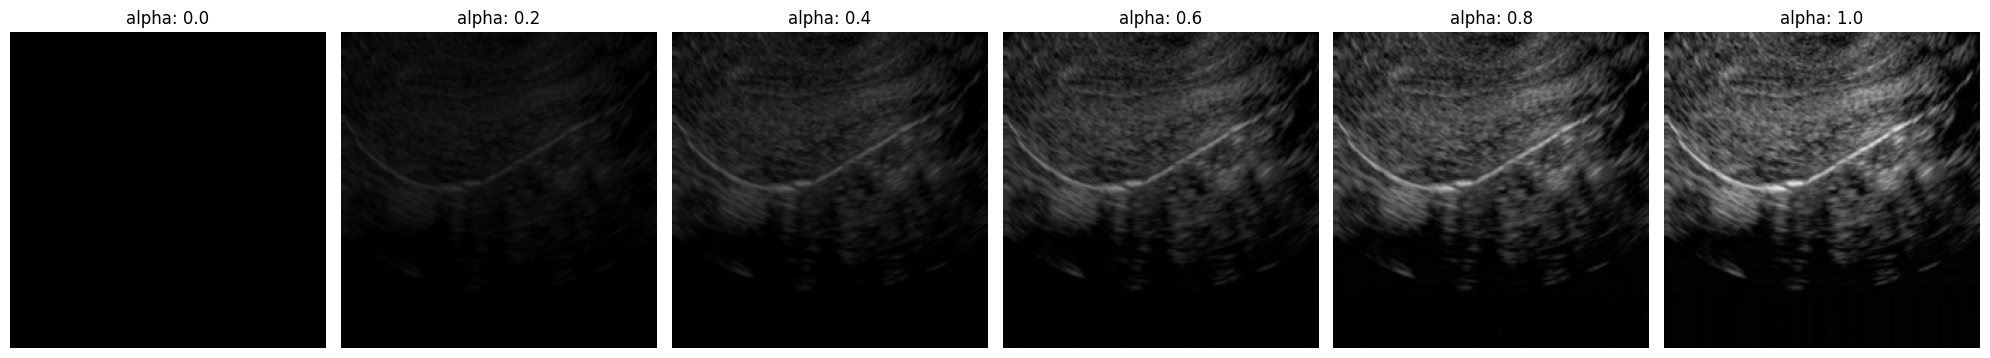

In [9]:
#figure showing the image with different alpha values and interpolation
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [14]:
from keras.models import load_model

In [16]:
#load model
model = load_model(r"C:\Users\shrey\OneDrive\Documents\misahub\bestmodel.h5")

In [59]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.sigmoid(logits)[:target_class_idx]
  return tape.gradient(probs, images)

In [96]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=555)

In [205]:
path_gradients.shape

TensorShape([51, 224, 224, 3])

In [327]:
import matplotlib

In [98]:
pred = model(interpolated_images)

In [197]:
pred_proba = tf.nn.sigmoid(pred)

In [340]:
pred_proba

<tf.Tensor: shape=(51, 1), dtype=float32, numpy=
array([[0.6538392 ],
       [0.59575975],
       [0.50097156],
       [0.50826156],
       [0.5621291 ],
       [0.5923387 ],
       [0.55257434],
       [0.53764457],
       [0.5341546 ],
       [0.55491024],
       [0.5994321 ],
       [0.61589533],
       [0.5435526 ],
       [0.50669867],
       [0.50117373],
       [0.50030535],
       [0.50014657],
       [0.5000746 ],
       [0.50004435],
       [0.50002426],
       [0.5000165 ],
       [0.50001615],
       [0.50001687],
       [0.50001645],
       [0.5000202 ],
       [0.50002074],
       [0.5000207 ],
       [0.50002265],
       [0.5000177 ],
       [0.50001293],
       [0.5000085 ],
       [0.50000614],
       [0.50000393],
       [0.50000274],
       [0.50000197],
       [0.5000014 ],
       [0.500001  ],
       [0.5000009 ],
       [0.5000008 ],
       [0.50000066],
       [0.50000054],
       [0.50000054],
       [0.5000005 ],
       [0.5000004 ],
       [0.5000004 ],
      

In [413]:
def show_path_grad(img_path):
    alphas=tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    interpolated_images = interpolate_images(
    baseline=baseline,
    image=read_image(img_path),
    alphas=alphas)
    path_gradients=compute_gradients(images=interpolated_images,target_class_idx=555)
    plt.imshow(read_image(img_path),origin='lower')
    x=(path_gradients[0]*10**3.35)+100
    y=100+(path_gradients[1]*10**3.35)

    plt.scatter(x,y,marker=".",s=0.1)
    plt.xlim(0,200)
    plt.ylim(0,200)

=========================================================================================================================================================

INTERPRETABILITY PLOT USING INTEGRAL GRADIENT

In [68]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [69]:
ig = integral_approximation(
    gradients=path_gradients)

In [70]:
print(ig.shape)

(224, 224, 3)


In [71]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [72]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [86]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=read_image(img_path),
                                       target_class_idx=555,
                                       m_steps=240)

In [115]:
print(ig_attributions.shape)

(224, 224, 3)


In [407]:
def show_int_grad(img_path):
    baseline = tf.zeros(shape=(224,224,3))
    ig_attributions=integrated_gradients(baseline=baseline,
                                       image=read_image(img_path),
                                       target_class_idx=555,
                                       m_steps=240)
    plt.imshow(read_image(img_path))
    plt.scatter((ig_attributions[0]*10**6.35)+100,100+(ig_attributions[1]*10**6.35),marker=".")
    plt.xlim(0,200)
    plt.ylim(0,200)

=========================================================================================================================================================

INTERPRETABILITY FOR TRAINING SET

#Gradient Saturation

In [129]:
import os

In [132]:
path1 =r'C:\Users\shrey\OneDrive\Documents\misahub\PCOSGen-train\PCOSGen-train\PCOSGen-train\images\0'

In [168]:
f=path1+r"\2image3.jpg"
img2 = read_image(f)
img2.shape

TensorShape([224, 224, 3])

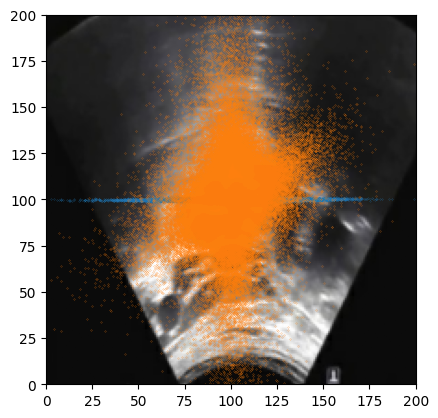

In [414]:
for i,file in enumerate(os.listdir(path1),start=1):
    if i == 3:
        break
    file_path=os.path.join(path1,file)
    show_path_grad(file_path)

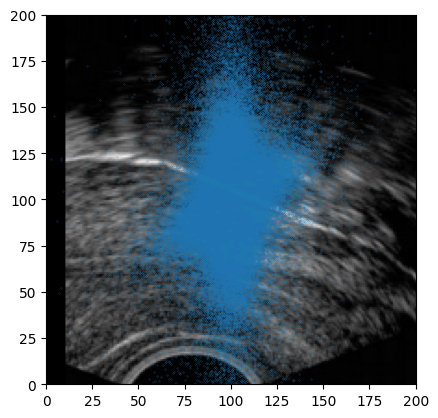

In [416]:
fp=path1+r"/image3823.jpg"
show_path_grad(fp)

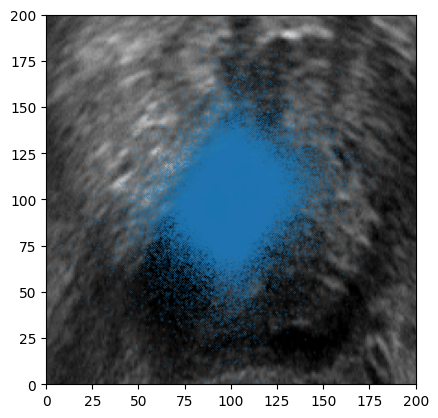

In [420]:
fp=r"C:\Users\shrey\OneDrive\Documents\misahub\PCOSGen-train\PCOSGen-train\PCOSGen-train\images\0\normal_15.jpg"
show_path_grad(fp)

In [ ]:
fp=r"C:\Users\shrey\OneDrive\Documents\misahub\PCOSGen-train\PCOSGen-train\PCOSGen-train\images\0\normal_15.jpg"
show_path_grad(fp)

In [ ]:
fp=r"C:\Users\shrey\OneDrive\Documents\misahub\PCOSGen-train\PCOSGen-train\PCOSGen-train\images\0\normal_15.jpg"
show_path_grad(fp)

#Integration Gradient

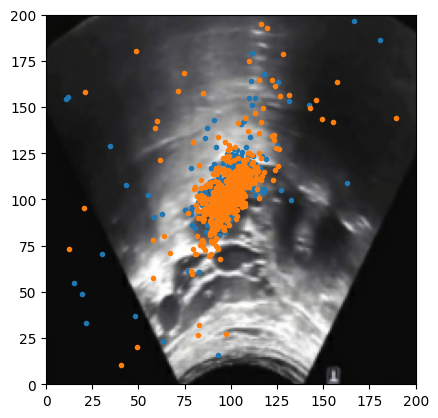

In [412]:
for i,file in enumerate(os.listdir(path1),start=1):
    if i == 3:
        break
    file_path=os.path.join(path1,file)
    show_int_grad(file_path)